# Active Learning

Active learning is used when we have some sort of scoring function that is too computationally expensive to label the full library of compounds. A machine learning model is trained on a subset of the data and used to score all compounds from within the library. The compounds with the best scores from the ML are labelled using the more expensive function, and the data from this pooled and used to train a new machine learning model. This cycle is repeated until a finish criteria is met. 

Currently this example trains a model to find the compound in the library with the lowerest calculated LogP value, but this scoring function can be replaced.

The initial steps in this notebook are:
1. A random sample of the unlabelled data is selected and labelled using the expensive scoring function
2. These labelled datapoints are used to train a simple machine learning (random forest) regressor

Followed the a repeating cycle:

3. The regressor is used to score the entire library
4. The compounds with the highest scores from the machine learning regressor are labelled using the expensive scoring function
5. The labels from the expensive scoring function are pooled and the machine learning model is re-trained

## Imports

In [1]:
import logging
import math
import time
from itertools import product
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from rdkit import Chem
from rdkit.Chem import AllChem, Descriptors, PandasTools
from sklearn.ensemble import RandomForestRegressor
from tqdm import tqdm

logging.basicConfig(
    format="[%(asctime)s] %(levelname)s: %(message)s",
    level=logging.INFO,
    handlers=[
        logging.StreamHandler(),
    ],
)

log = logging.getLogger(__name__)

Failed to find the pandas get_adjustment() function to patch
Failed to patch pandas - PandasTools will have limited functionality


## Defining some useful functions

In [2]:
def build_virtual_library() -> pd.DataFrame:
    """Constructs a virtual library by coupling building blocks from the input smi files.

    Returns:
        pd.DataFrame: A DataFrame containing the molecular objects and SMILES strings of the products.
    """
    log.info("Building virtual library")
    try:
        library = pd.read_csv("data/library.csv", index_col="smiles")
        library["mol"] = [Chem.MolFromSmiles(s) for s in tqdm(library.index.to_list())]
    except FileNotFoundError:
        reaction_smarts = "N[c:4][c:3]C(O)=O.[#6:1][NH2].[#6:2]C(=O)[OH]>>[C:2]c1n[c:4][c:3]c(=O)n1[C:1]"
        bb_types = ["aminobenzoic", "carboxylic_acids", "primary_amines"]
        rxn = AllChem.ReactionFromSmarts(reaction_smarts)

        building_blocks = []
        for bb in bb_types:
            smil = []
            with open(Path(f"data/{bb}_100.smi"), "r") as f:
                for line in f.readlines():
                    smiles, _ = line.split()
                    smil.append(smiles)
            building_blocks.append(smil)

        total_prods = math.prod([len(x) for x in building_blocks])

        product_list = []
        for reagents in tqdm(product(*building_blocks), total=total_prods):
            reagent_mol_list = [Chem.MolFromSmiles(x) for x in reagents]
            products = rxn.RunReactants(reagent_mol_list)
            if products:
                Chem.SanitizeMol(products[0][0])
                product_list.append(products[0][0])
        library = pd.DataFrame(
            product_list,
            index=[Chem.MolToSmiles(m) for m in product_list],
            columns=["mol"],
        )
        library.index.name = "smiles"
        library["slow_scores"] = np.NaN
        library["model_scores"] = np.NaN
        PandasTools.AddMurckoToFrame(library, molCol="mol", MurckoCol="scaffold")
        library.to_csv("data/library.csv")
    log.info("Virtual library built with %s products", len(library))
    return library


def rdkit_logp(mol) -> float:
    """Calculates the logP of the input molecule."""
    return Descriptors.MolLogP(mol)


def slow_function(mols: pd.Series) -> np.array:
    """The slow scoring function. This function takes too long to score the entire library.

    Args:
        mols (pd.Series): The input molecules.

    Returns:
        np.arary: The scores of the molecules.
    """
    log.info("Scoring %s compounds with slow scoring function", len(mols))
    return np.array([rdkit_logp(mol) for mol in tqdm(mols)])


def create_morgan_fingerprints(library: pd.DataFrame) -> pd.DataFrame:
    """Creates Morgan fingerprints for the input library.

    Args:
        library (pd.DataFrame): The input library.

    Returns:
        pd.DataFrame: The Morgan fingerprints of the input library.
    """
    log.info("Creating Morgan fingerprints")
    try:
        fps_df = pd.read_csv("data/fingerprints.csv").set_index("smiles")
        fps_df.fillna("", inplace=True)
    except FileNotFoundError:
        fps = [
            list(AllChem.GetMorganFingerprintAsBitVect(mol, radius=2))
            for mol in tqdm(library.mol)
        ]
        fps_df = pd.DataFrame(
            fps, columns=[f"fp_{x}" for x in range(len(fps[0]))], index=library.index
        )
        fps_df.to_csv("data/fingerprints.csv")
    return fps_df


def train_ml_model(
    library: pd.DataFrame, fingerprints: pd.DataFrame
) -> RandomForestRegressor:
    """Trains a random forest regressor model on slow scores for the input library.

    Args:
        library (pd.DataFrame): The input library.
        fingerprints (pd.DataFrame): The Morgan fingerprints of the input library.

    Returns:
        RandomForestRegressor: The trained random forest regressor model.
    """
    log.info("Training model with slow scores")
    scored = library[~library["slow_scores"].isna()]
    X = fingerprints.loc[scored.index]
    y = scored["slow_scores"]
    regressor = RandomForestRegressor()
    regressor.fit(X, y)
    return regressor


def score_compounds(X: pd.DataFrame, regressor: RandomForestRegressor) -> np.array:
    """Scores the input compounds with the trained models.

    Args:
        X (pd.DataFrame): The input compounds.
        regressors (list[RandomForestRegressor]): The trained random forest regressor models.

    Returns:
        np.array: The input compounds with the model scores.
    """
    return regressor.predict(X)


def score_library(
    library: pd.DataFrame,
    regressor: RandomForestRegressor,
    fingerprints: pd.DataFrame,
) -> pd.DataFrame:
    """Scores the entire library with the trained model.

    Args:
        library (pd.DataFrame): The input library.
        regressor (RandomForestRegressor): The trained random forest regressor model.
        fingerprints (pd.DataFrame): The Morgan fingerprints of the input library.

    Returns:
        pd.DataFrame: The input library with the model scores.
    """
    log.info("Scoring entire library with model")
    library["model_scores"] = score_compounds(fingerprints, regressor)
    return library

## Active learning pipeline

In [3]:
def run_active_learning(
    library: pd.DataFrame,
    fingerprints: pd.DataFrame,
    compounds_per_round: int,
    number_of_rounds: int,
    minimize: bool,
) -> tuple[float, float, float]:
    """Runs active learning on the virtual library.

    Args:
        library (pd.DataFrame): The input virtual library.
        fingerprints (pd.DataFrame): The Morgan fingerprints of the input library.
        compounds_per_round (int): Number of compounds to select per round.
        number_of_rounds (int): Number of active learning rounds.
        minimize (bool): Whether to minimize or maximize the slow scoring function.

    Returns:
        tuple[float, float, float]: The true best score, the active learning best score,
        and the random sample best score.
    """
    # Select initial random sample
    start = time.time()
    initial_sample = library.sample(compounds_per_round)
    library["slow_scores"] = np.NaN

    # Score the initial sample
    initial_scores = slow_function(initial_sample.mol)

    # Save the slow scores
    library.loc[initial_sample.index, "slow_scores"] = initial_scores

    # Run active learning
    for al_round in range(number_of_rounds):
        log.info("Active learning round %s", al_round + 1)

        # Train the ML model
        model = train_ml_model(library, fingerprints)

        # Use the model to score the entire virtual library
        library = score_library(library, model, fingerprints)

        # Select the top scoring molecules with no slow scores
        top_compounds = (
            library[library["slow_scores"].isna()]
            .sort_values("slow_scores", ascending=minimize)
            .head(compounds_per_round)
        )

        # Score the top molecules with the slow function
        slow_scores = slow_function(top_compounds.mol)

        # Save the slow scores
        library.loc[top_compounds.index, "slow_scores"] = slow_scores

    if MINIMIZE:
        true_best = library.true_scores.min()
        al_best = library.slow_scores.min()
        random_best = library.sample(library.slow_scores.count()).true_scores.min()
    else:
        true_best = library.true_scores.max()
        al_best = library.slow_scores.max()
        random_best = library.sample(library.slow_scores.count()).true_scores.max()

    end = time.time()
    log.info("Active learning took %.1f seconds", end - start)
    return true_best, al_best, random_best


# Active learning parameters
COMPOUNDS_PER_ROUND = 5
NUMBER_OF_ROUNDS = 5
MINIMIZE = True

# Create the virtual library
library = build_virtual_library()

# Calculate true values for comparison (only possible due to the quick scoring fuction)
library["true_scores"] = [rdkit_logp(mol) for mol in library["mol"]]

# Create morgan fingerprints for the library
fingerprints = create_morgan_fingerprints(library)

true_best, al_best, random_best = run_active_learning(
    library, fingerprints, COMPOUNDS_PER_ROUND, NUMBER_OF_ROUNDS, MINIMIZE
)

log.info(
    f"True best: {true_best:.2f}, AL best: {al_best:.2f}, Random sample best: {random_best:.2f}"
)

start = time.time()
[rdkit_logp(mol) for mol in library["mol"]]
end = time.time()
log.info(
    "Scoring entire library with slow scoring function took %.1f seconds", end - start
)

[2024-02-15 13:16:48,662] INFO: Building virtual library
100%|██████████| 1000000/1000000 [01:39<00:00, 10065.71it/s]
[2024-02-15 13:18:48,278] INFO: Virtual library built with 132500 products
[2024-02-15 13:19:13,279] INFO: Creating Morgan fingerprints
100%|██████████| 132500/132500 [04:04<00:00, 542.98it/s]
[2024-02-15 13:24:39,631] INFO: Scoring 5 compounds with slow scoring function
100%|██████████| 5/5 [00:00<00:00, 22623.00it/s]
[2024-02-15 13:24:39,642] INFO: Active learning round 1
[2024-02-15 13:24:39,642] INFO: Training model with slow scores
[2024-02-15 13:24:39,696] INFO: Scoring entire library with model
[2024-02-15 13:24:39,988] INFO: Scoring 5 compounds with slow scoring function
100%|██████████| 5/5 [00:00<00:00, 60262.99it/s]
[2024-02-15 13:24:39,989] INFO: Active learning round 2
[2024-02-15 13:24:39,990] INFO: Training model with slow scores
[2024-02-15 13:24:40,043] INFO: Scoring entire library with model
[2024-02-15 13:24:40,341] INFO: Scoring 5 compounds with slow

## Analysis of the results

### What does the distribution of true scores look like?

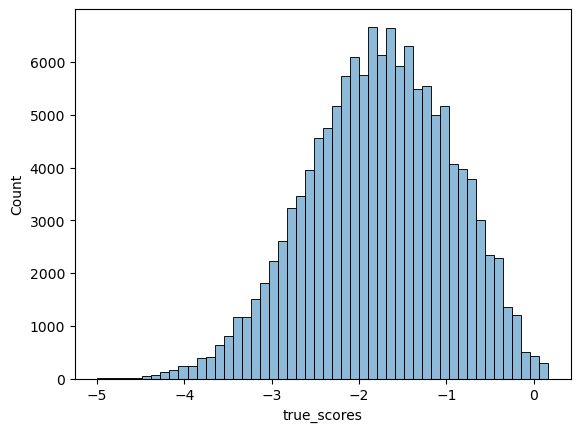

In [4]:
sns.histplot(library.true_scores, bins=50, alpha=0.5, label="True scores")
plt.show()

### Does active learning outperform random sampling?

Yes. Active learning reliably finds the lowest value in the library after labelling only 15 componds with the expensive scoring function. A random search will sometime find the lowest value, but even with 500 labelled compounds it does not always find the lowest value.

[2024-02-15 13:24:42,255] INFO: Scoring 5 compounds with slow scoring function
100%|██████████| 5/5 [00:00<00:00, 58092.85it/s]
[2024-02-15 13:24:42,258] INFO: Active learning round 1
[2024-02-15 13:24:42,259] INFO: Training model with slow scores
[2024-02-15 13:24:42,315] INFO: Scoring entire library with model
[2024-02-15 13:24:42,612] INFO: Scoring 5 compounds with slow scoring function
100%|██████████| 5/5 [00:00<00:00, 86302.55it/s]
[2024-02-15 13:24:42,616] INFO: Active learning took 0.4 seconds
[2024-02-15 13:24:42,620] INFO: Scoring 5 compounds with slow scoring function
100%|██████████| 5/5 [00:00<00:00, 100342.20it/s]
[2024-02-15 13:24:42,621] INFO: Active learning round 1
[2024-02-15 13:24:42,621] INFO: Training model with slow scores
[2024-02-15 13:24:42,670] INFO: Scoring entire library with model
[2024-02-15 13:24:42,962] INFO: Scoring 5 compounds with slow scoring function
100%|██████████| 5/5 [00:00<00:00, 92385.55it/s]
[2024-02-15 13:24:42,964] INFO: Active learning ro

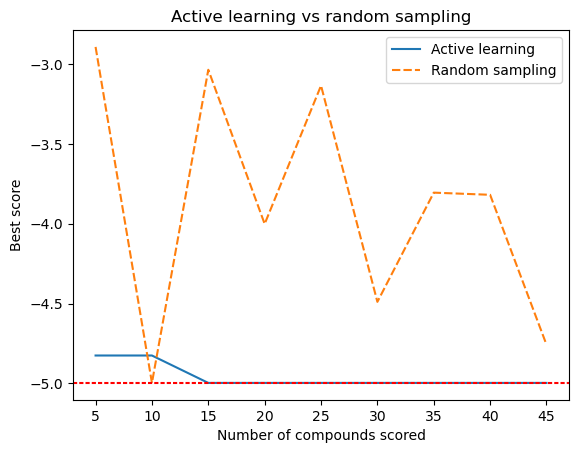

In [5]:
al_scores = []
random_scores = []
rng = range(1, 10)
for i in rng:
    _, al_best, random_best = run_active_learning(
        library, fingerprints, COMPOUNDS_PER_ROUND, i, MINIMIZE
    )
    al_scores.append(al_best)
    random_scores.append(random_best)

ax = sns.lineplot(
    pd.DataFrame(
        {"Active learning": al_scores, "Random sampling": random_scores},
        index=[x * COMPOUNDS_PER_ROUND for x in rng],
    )
)
ax.set(
    xlabel="Number of compounds scored",
    ylabel="Best score",
    title="Active learning vs random sampling",
    xticks=[x * COMPOUNDS_PER_ROUND for x in rng],
)
ax.axhline(library.true_scores.min(), color="red", dashes=[2, 1])
plt.show()

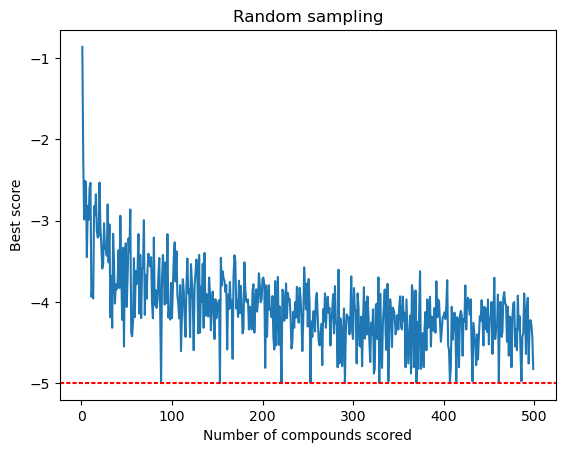

In [6]:
rands = []
rng = range(1, 500)
for x in rng:
    random_max = library.sample(x).true_scores.min()
    rands.append(random_max)

ax = sns.lineplot(y=rands, x=rng)
ax.set(
    xlabel="Number of compounds scored",
    ylabel="Best score",
    title="Random sampling",
)
ax.axhline(library.true_scores.min(), color="red", dashes=[2, 1])
plt.show()